In [1]:
using MAT
using Plots
using LinearAlgebra
using DifferentialEquations
using Random
using Statistics
using LaTeXStrings

In [2]:
loaded = matread("./data/allsamples.mat")

C_span = Float64.(loaded["allC"])
G_span = Float64.(loaded["allG"])
Sstar_span = Float64.(loaded["allSstar"])
Rstar_span = Float64.(loaded["allRstar"])

Nr = loaded["Nr"]
Ns_span = loaded["Ns_span"]

num_try = loaded["num_try"]
rho_span = Float64.(loaded["rho_span"])
batch_size = 10 # 10 different initial conditions

10

In [22]:
function ResCon!(du,u,para,t)
    N_s,N_r,G,C,g,δ = para
    du[1:N_s] = u[1:N_s].*(G*u[N_s+1:N_r+N_s] - δ) + 1e-7*ones(N_s) 
    du[N_s+1:N_r+N_s] = g - u[N_s+1:N_r+N_s].*(C'*u[1:N_s])
end

ResCon! (generic function with 1 method)

In [88]:
i = 40 # Ns
Ns = Ns_span[i]
j = 40 # rho

C = C_span[i,j,1:Ns,:]
G = G_span[i,j,1:Ns,:]

k = 1 # R^* and S^*

Sstar = Sstar_span[i,j,k,1:Ns]
Rstar = Rstar_span[i,j,k,:]

δ = G * Rstar
g = Rstar.*(C'*Sstar)

# sample an initial condition
u0 = zeros(Ns+Nr)
u0[1:Ns] = Sstar .* (1 .+ .5*(rand(Ns) .- 0.5))
u0[Ns+1:end] = Rstar .* (1 .+ .5*(rand(Nr) .- 0.5))
iter = 1

tspan = (0.0, 5000.0)
para = (Ns,Nr,G,C,g,δ)

stop = 0
fstate = zeros(Ns+2) # fstate[1:Ns]: species abundance; fstate[Ns+1]: flucturate or not; 
# fstate[Ns+2]: surviving fraction
while stop == 0
    prob = ODEProblem(ResCon!,u0,tspan,para)
    #VCABM3() or Tsit5()
    global sol = solve(prob, saveat = 10.0, Tsit5())
    meanS = mean(sol.u[end-100:end])[1:Ns]
    global index = findall(meanS .> 1e-5)
    global flagS = mean(abs.((sol.u[end][index] - meanS[index])./meanS[index]))
    if iter == 15 || flagS <= 1e-3
        stop = 1
    end
    iter = iter + 1
    u0 = sol.u[end]
end
print("running time = ",(iter-1)*5000," surviving fraction: ", length(index)/Ns)

fluc = 0
if (flagS > 0.05) & (iter == 16)
    fluc = 1
end

fstate[1:Ns] = u0[1:Ns] # so we don't need to global sol later!
fstate[Ns+1] = fluc
fstate[Ns+2] = length(index)/Ns

running time = 75000 surviving fraction: 1.0

1.0

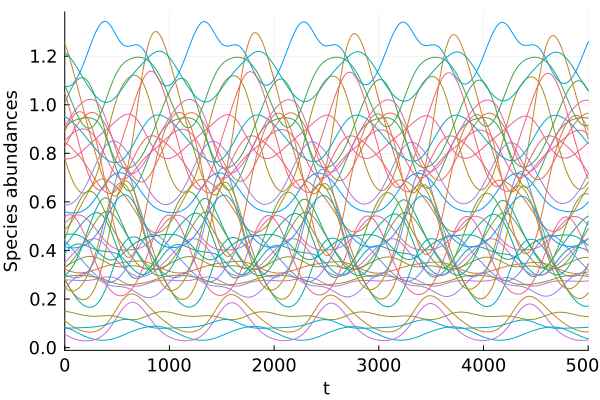

In [89]:
plot(sol,idxs = 1:Ns,legend = false,
    ylabel="Species abundances",
    xtickfont=font(12),
    ytickfont=font(12),
    guidefont=font(12),
    legendfont=font(12))

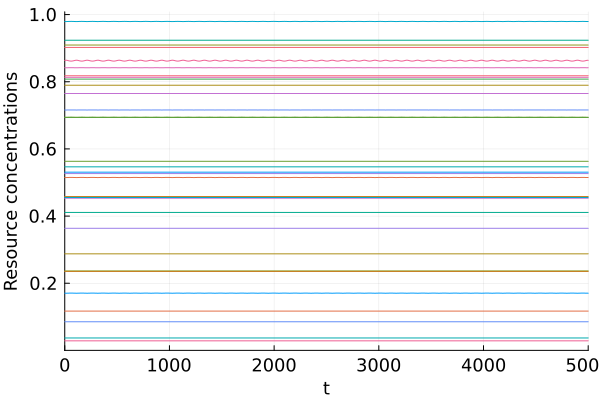

In [31]:
plot(sol,idxs = Ns+1:Ns+Nr,legend = false,
    ylabel="Resource concentrations",
    xtickfont=font(12),
    ytickfont=font(12),
    guidefont=font(12),
    legendfont=font(12))

We try a batch now

In [90]:
i = 40 # Ns
Ns = Ns_span[i]
j = 40 # rho

C = C_span[i,j,1:Ns,:]
G = G_span[i,j,1:Ns,:]

k = 1 # R^* and S^*

Sstar = Sstar_span[i,j,k,1:Ns]
Rstar = Rstar_span[i,j,k,:]

δ = G * Rstar
g = Rstar.*(C'*Sstar)

tspan = (0.0, 5000.0) # time for one test solution
para = (Ns,Nr,G,C,g,δ)

fstate = zeros(batch_size,Ns+2)
# fstate[1:Ns]: species abundance; fstate[Ns+1]: flucturate or not; 
# fstate[Ns+2]: surviving fraction

for batch in 1:batch_size
# sample an initial condition
u0 = zeros(Ns+Nr)
u0[1:Ns] = Sstar .* (1 .+ .5*(rand(Ns) .- 0.5))
u0[Ns+1:end] = Rstar .* (1 .+ .5*(rand(Nr) .- 0.5))
iter = 1

stop = 0
while stop == 0
    prob = ODEProblem(ResCon!,u0,tspan,para)
    #VCABM3() or Tsit5()
    sol = solve(prob, saveat = 10.0, Tsit5())
    meanS = mean(sol.u[end-100:end])[1:Ns]
    global index = findall(meanS .> 1e-5)
    global flagS = mean(abs.((sol.u[end][index] - meanS[index])./meanS[index]))
    if iter == 15 || flagS <= 1e-3
        stop = 1
    end
    iter = iter + 1
    u0 = sol.u[end]
end
print("running time = ",(iter-1)*5000," surviving fraction: ", length(index)/Ns) # comment this later

fluc = 0.0
if (flagS > 0.01) & (iter == 16)
    fluc = 1.0
end

fstate[batch,1:Ns] = u0[1:Ns] # so we don't need to global sol later!
fstate[batch,Ns+1] = fluc
fstate[batch,Ns+2] = length(index)/Ns
end

running time = 75000 surviving fraction: 0.8837209302325582

running time = 15000 surviving fraction: 0.37209302325581395

running time = 75000 surviving fraction: 0.7906976744186046

running time = 10000 surviving fraction: 0.37209302325581395

running time = 15000 surviving fraction: 0.37209302325581395

running time = 75000 surviving fraction: 1.0

running time = 10000 surviving fraction: 0.37209302325581395

running time = 10000 surviving fraction: 0.37209302325581395

running time = 75000 surviving fraction: 0.813953488372093

running time = 20000 surviving fraction: 0.37209302325581395

In [91]:
# see mean fluc fraction
#fstate[:,Ns+1]
#mean(fstate[:,Ns+1])
# see mean surviving fraction
#mean(fstate[:,Ns+2])
# if mean fluc fraction < 1
nonfluc_idx = findall(x -> x == 0.0, fstate[:,Ns+1])
innerprod = fstate[nonfluc_idx,1:Ns] * (fstate[nonfluc_idx,1:Ns])'
innerprod = diagm(sqrt.(diag(innerprod)).^(-1)) * innerprod * diagm(sqrt.(diag(innerprod)).^(-1))
PCA = real(eigvals(innerprod))
length(PCA[PCA .> 0.1])

1